In [24]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from pathlib import Path
import matplotlib as mpl


import sys, os
sys.path.append(os.path.abspath("../../.."))

from Forward.grav3D import grav3D_8091
from Forward.utils import calculateKernelGrav

In [25]:
# 1) Receptores desde .npy

receivers_path = r"D:\8091_project\P8091\Examples\Modelling\Grav_modelC\receivers_modelC.npy"
obs_xyz = np.load(receivers_path).astype(np.float32)  # (nObs, 3)

if obs_xyz.ndim != 2 or obs_xyz.shape[1] != 3:
    raise ValueError(f"receivers_modelC.npy debe tener forma (nObs,3). Encontré: {obs_xyz.shape}")

In [26]:
# 2) Modelo

model_path = r"D:\8091_project\P8091\models\modelC\grav_modelC.npz"
model_npz = np.load(model_path)

cell_centers = model_npz["cell_centers"].astype(np.float32)   # (nC, 3)
density_vol  = model_npz["Grav_model"].astype(np.float32)     # (nC,)

density_contrast_flat = (density_vol.T) * 1000      # kg/m^3

dx = float(model_npz["dx"])
dy = float(model_npz["dy"])
dz = float(model_npz["dz"])

full_mesh = {"cell_centers": cell_centers, "dx": dx, "dy": dy, "dz": dz}

density_contrast_active = torch.as_tensor(density_contrast_flat, dtype=torch.float32)

In [27]:
# 3) Kernel

kernelcal = calculateKernelGrav(
    density_contrast_model=density_contrast_active,
    mesh=full_mesh,
    receiver_locations=obs_xyz
)

In [28]:
# 4) Forward

gz_custom_mgal = grav3D_8091(
    density_contrast_model=density_contrast_active,
    K=kernelcal,
    to_mgal=True
)

data_torch = gz_custom_mgal.detach().cpu().numpy().ravel()
locs_torch = obs_xyz[:, :2]

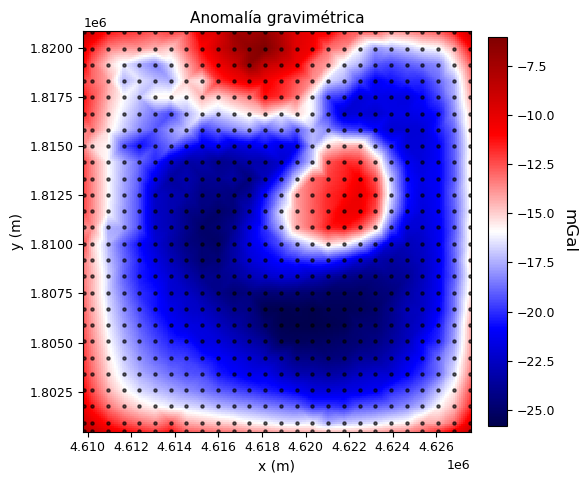

In [29]:
# 5) Plot

valid = np.isfinite(data_torch)
vmin_t, vmax_t = data_torch[valid].min(), data_torch[valid].max()
cmap = "seismic"

def plot_scattered_field(ax, locs, values, vmin, vmax, title, cmap="seismic", nx=200, ny=200):
    x, y = locs[:, 0], locs[:, 1]
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    XI, YI = np.meshgrid(xi, yi)

    interp = LinearNDInterpolator(np.c_[x, y], values)
    Zi = interp(XI, YI)

    im = ax.pcolormesh(XI, YI, Zi, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.scatter(x, y, s=5, c="k", alpha=0.6)
    return im

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
mappable = plot_scattered_field(
    ax, locs_torch, data_torch,
    vmin=vmin_t, vmax=vmax_t,
    title="Anomalía gravimétrica",
    cmap=cmap
)

cbar = fig.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mGal", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

C:\Users\aapm1\AppData\Local\Temp\ipykernel_4152\2781564770.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_model = mpl.cm.get_cmap("viridis").copy()
C:\Users\aapm1\AppData\Local\Temp\ipykernel_4152\2781564770.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.06, 0.06, 0.94, 0.98])


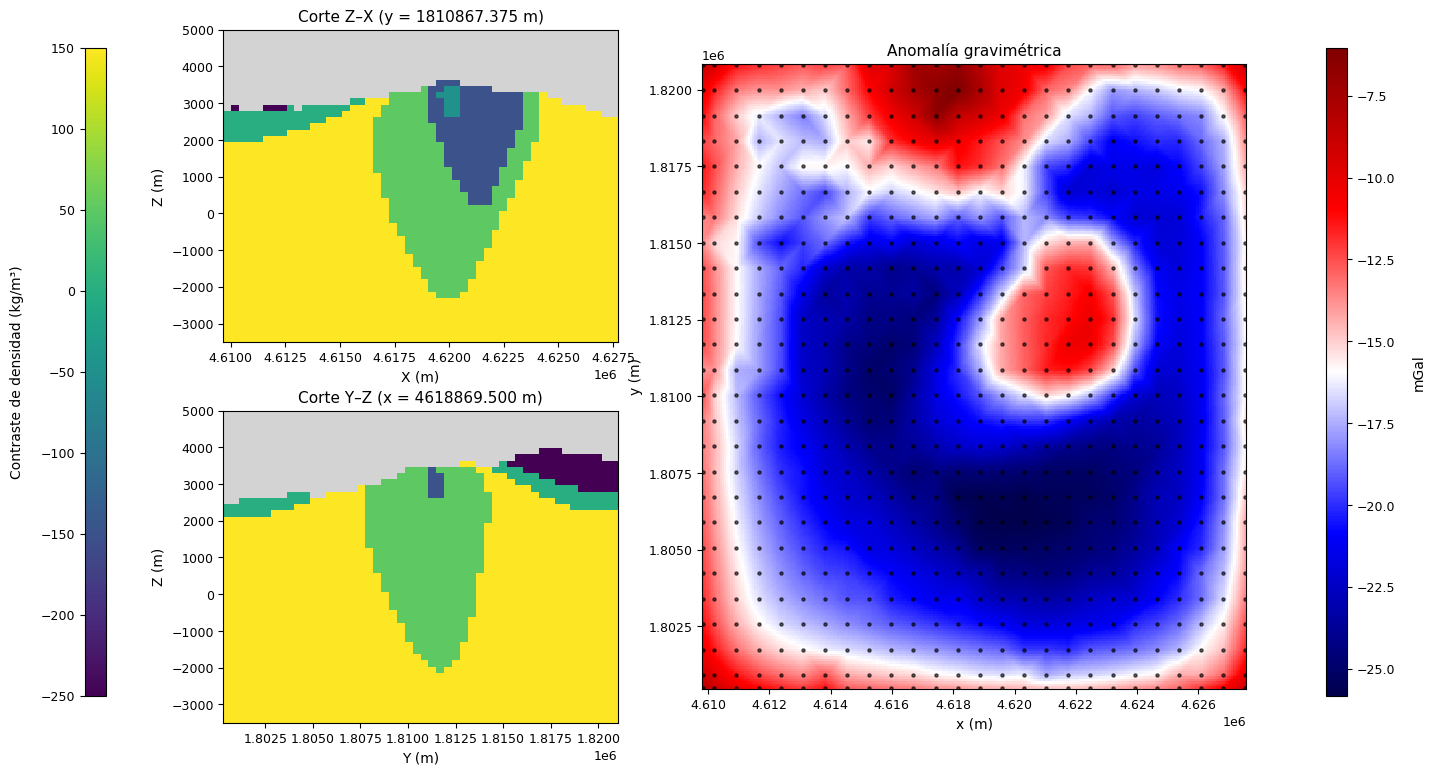

Guardado: D:\8091_project\P8091\Examples\Modelling\Grav_modelC\Modeling_modelC.png


In [30]:
mpl.rcParams.update({
    "font.size": 12, "axes.titlesize": 11, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
})


rho_active_np = density_contrast_active.detach().cpu().numpy().ravel()

cent = np.asarray(cell_centers, float)
x_c, y_c, z_c = cent[:,0], cent[:,1], cent[:,2]

x_unique = np.unique(x_c); y_unique = np.unique(y_c); z_unique = np.unique(z_c)
nx, ny, nz = len(x_unique), len(y_unique), len(z_unique)

if nx * ny * nz != rho_active_np.size:
    raise RuntimeError(f"No cuadra: {nx}*{ny}*{nz} != {rho_active_np.size}")

# índices
ix = np.searchsorted(x_unique, x_c)
iy = np.searchsorted(y_unique, y_c)
iz = np.searchsorted(z_unique, z_c)

rho_3d = np.full((nz, ny, nx), np.nan, float)
rho_3d[iz, iy, ix] = rho_active_np

rho3d = rho_3d.T 


iy_slice = ny // 2
ix_slice = nx // 2
y_slice_value = float(y_unique[iy_slice])
x_slice_value = float(x_unique[ix_slice])

rho_xz = rho3d[:, iy_slice, :]
rho_yz = rho3d[ix_slice, :, :]

dx_m = np.median(np.diff(x_unique)) if nx > 1 else 1.0
dy_m = np.median(np.diff(y_unique)) if ny > 1 else 1.0
dz_m = np.median(np.diff(z_unique)) if nz > 1 else 1.0

x_edges = np.r_[x_unique[0] - dx_m/2, x_unique + dx_m/2]
y_edges = np.r_[y_unique[0] - dy_m/2, y_unique + dy_m/2]
z_edges = np.r_[z_unique[0] - dz_m/2, z_unique + dz_m/2]


rho_min = np.nanmin(rho_active_np)
rho_max = np.nanmax(rho_active_np)

cmap_model = mpl.cm.get_cmap("viridis").copy()
cmap_model.set_bad(color="lightgrey")
norm_model = mpl.colors.Normalize(vmin=rho_min, vmax=rho_max)

C_xz = np.ma.masked_invalid(rho_xz.T)
C_yz = np.ma.masked_invalid(rho_yz.T)

locs_torch = np.asarray(obs_xyz[:, :2], float)
data_torch = np.asarray(gz_custom_mgal, float).ravel()

valid_torch = np.isfinite(data_torch) & np.isfinite(locs_torch[:,0]) & np.isfinite(locs_torch[:,1])
locs_torch = locs_torch[valid_torch]
data_torch = data_torch[valid_torch]

vmin_t = data_torch.min()
vmax_t = data_torch.max()

def plot_scattered_field(ax, locs, values, vmin, vmax, title, cmap="seismic", nx=200, ny=200):
    x = locs[:, 0]
    y = locs[:, 1]

    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    XI, YI = np.meshgrid(xi, yi)

    interp = LinearNDInterpolator(np.c_[x, y], values)
    Zi = interp(XI, YI)

    im = ax.pcolormesh(
        XI, YI, Zi,
        shading="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.scatter(x, y, s=5, c="k", alpha=0.6)
    ax.set_aspect("equal", adjustable="box")

    return im

fig = plt.figure(figsize=(13.2, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[1.05, 1.45], wspace=0.18, hspace=0.22)

ax_zx  = fig.add_subplot(gs[0, 0])
ax_yz  = fig.add_subplot(gs[1, 0], sharey=ax_zx)
ax_map = fig.add_subplot(gs[:, 1])

pm_zx = ax_zx.pcolormesh(x_edges, z_edges, C_xz, cmap=cmap_model, norm=norm_model, shading="flat")
ax_zx.set_title(f"Corte Z–X (y = {y_slice_value:.3f} m)")
ax_zx.set_xlabel("X (m)")
ax_zx.set_ylabel("Z (m)")

pm_yz = ax_yz.pcolormesh(y_edges, z_edges, C_yz, cmap=cmap_model, norm=norm_model, shading="flat")
ax_yz.set_title(f"Corte Y–Z (x = {x_slice_value:.3f} m)")
ax_yz.set_xlabel("Y (m)")
ax_yz.set_ylabel("Z (m)")

mappable = plot_scattered_field(
    ax_map,
    locs_torch,
    data_torch,
    vmin=vmin_t,
    vmax=vmax_t,
    title="Anomalía gravimétrica",
    cmap="seismic",
    nx=250, ny=250
)


fig.tight_layout(rect=[0.06, 0.06, 0.94, 0.98])

cax_model = fig.add_axes([0.02, 0.14, 0.016, 0.72])
cb_model = fig.colorbar(pm_zx, cax=cax_model)
cb_model.set_label("Contraste de densidad (kg/m³)", rotation=90, labelpad=12)
cb_model.ax.yaxis.set_label_position("left")
cb_model.ax.yaxis.set_ticks_position("left")
cax_data = fig.add_axes([0.96, 0.14, 0.016, 0.72])
cb_data = fig.colorbar(mappable, cax=cax_data)
cb_data.set_label("mGal", rotation=90, labelpad=12)

plt.show()


out_png = r"D:\8091_project\P8091\Examples\Modelling\Grav_modelC\Modeling_modelC.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
print("Guardado:", out_png)

In [31]:
obs_xyz_np = np.asarray(obs_xyz, float)
resp_np    = np.asarray(gz_custom_mgal, float).reshape(-1)

if obs_xyz_np.ndim != 2 or obs_xyz_np.shape[1] != 3:
    raise ValueError(f"obs_xyz debe ser (nObs,3). Llegó: {obs_xyz_np.shape}")
if resp_np.size != obs_xyz_np.shape[0]:
    raise ValueError(f"Respuesta y obs no coinciden: {resp_np.size} vs {obs_xyz_np.shape[0]}")

out = np.column_stack([obs_xyz_np, resp_np])  # (nObs,4)

np.save("response_modelC.npy", out)